In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA


# step1 데이터구성하기

In [3]:
df = pd.read_csv("환율.csv", engine='python', parse_dates=['APPL_DATE'])
df.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


# step2 변동추세확인-시간에 따른 환율 추세 그래프 생성

/home/pirl/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


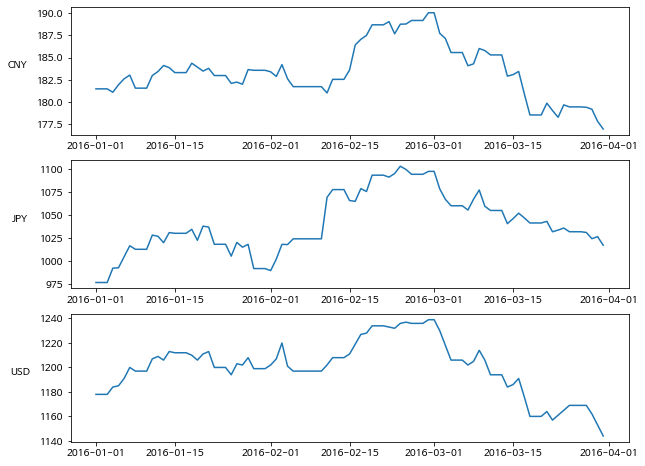

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,8))

for(ax, idx, currency) in zip([ax1,ax2,ax3],[311,312,313],['CNY','JPY','USD']):
    ax.plot("APPL_DATE", "STD_RATE", data=df[df['CURRENCY']==currency])
    ax.set_ylabel(currency,rotation=0, labelpad=20)
    


# step3 시계열분석 : 데이터분할 - 통화별 데이터 분할

In [6]:
df_CNY = df[df['CURRENCY']=='CNY'].set_index("APPL_DATE")
df_CNY.drop(['CURRENCY', "USD_CONV_DATE"],axis =1, inplace=True)

df_JPY = df[df['CURRENCY']=='JPY'].set_index("APPL_DATE")
df_JPY.drop(['CURRENCY', "USD_CONV_DATE"],axis =1, inplace=True)

df_USD = df[df['CURRENCY']=='USD'].set_index("APPL_DATE")
df_USD.drop(['CURRENCY', "USD_CONV_DATE"],axis =1, inplace=True)

df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


# step3 시계열분석 : 데이터분할 - train / test 데이터 분할

In [8]:
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [9]:
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print("shape of train data: ", df_CNY_train.shape)
print("shape of test data: ", df_CNY_test.shape)


shape of train data:  (82, 1)
shape of test data:  (9, 1)


# step3 시계열분석 : 데이터분할 - 차분을 통하여 정상성 데이터로 변환

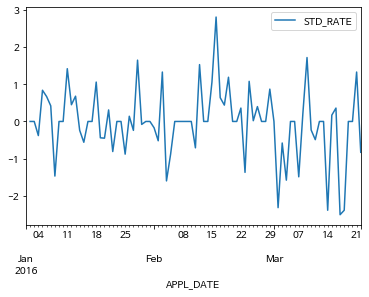

In [10]:
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

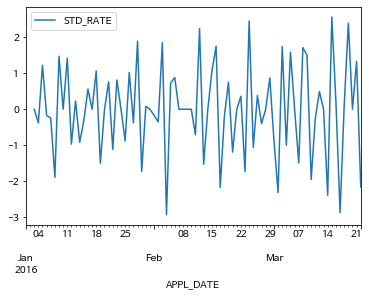

In [11]:
df_CNY_diff2 = df_CNY_train - 2*(df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

# step3 시계열분석 : 자기상관 함수 및 부분 자기상"관 함수

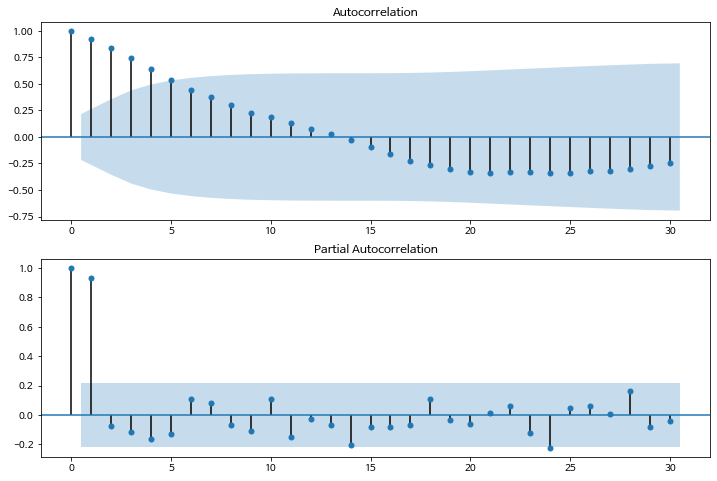

In [12]:
lag_size = 30
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train['STD_RATE'],lags=lag_size, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_CNY_train['STD_RATE'],lags=lag_size, ax=ax2)


# step3 시계열분석 : 시계열모델

In [13]:
ts_model_cny = ARIMA(df_CNY_train, order=(1,2,0))

ts_result_cny = ts_model_cny.fit(trend='c', full_output=True)
print(ts_result_cny.summary())

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Fri, 07 Feb 2020   AIC                            253.025
Time:                        14:20:22   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

# step4 예측 및 결과해석

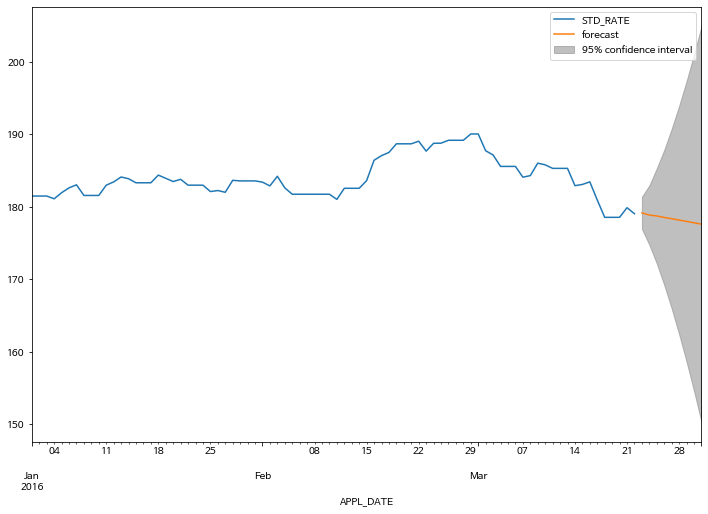

In [14]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig,ax = plt.subplots(figsize=(12,8))
ax = df_CNY_train.plot(ax=ax)

fig = ts_result_cny.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

In [15]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ='levels')
df_merge = df_CNY
df_merge['예측값'] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476898
2016-01-05,181.94,180.883667


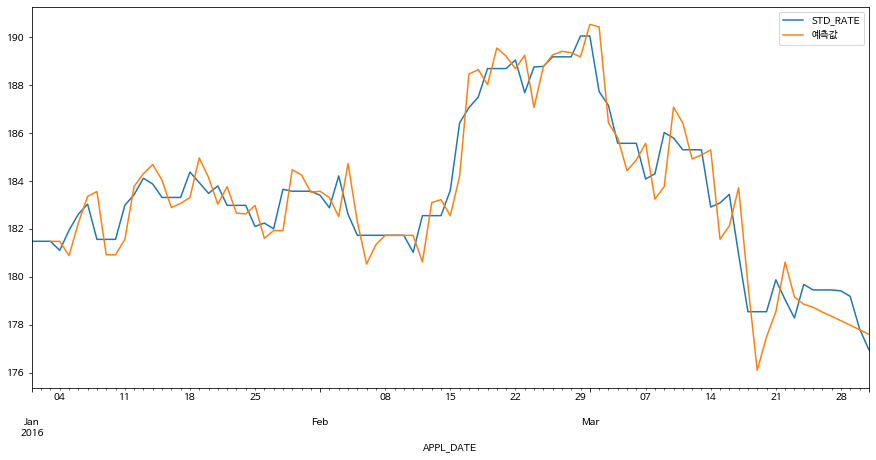

In [16]:
df_merge.plot(y=['STD_RATE', '예측값'],figsize=(15,7))

# step3 시계열분석 : 데이터분할 - 차분을 통하여 정상성 데이터로 변환

In [18]:
df_USD_train = df_USD[mask]
df_USD_test = df_USD[~mask]
print("shape of train data: ", df_USD_train.shape)
print("shape of test data: ", df_USD_test.shape)


shape of train data:  (82, 1)
shape of test data:  (9, 1)


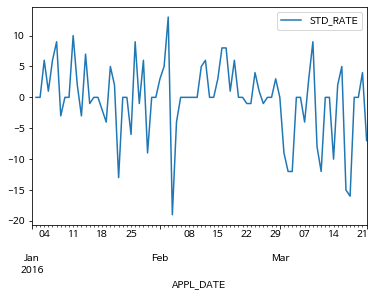

In [19]:
df_USD_diff1 = df_USD_train - df_USD_train.shift(1)
df_USD_diff1.plot()

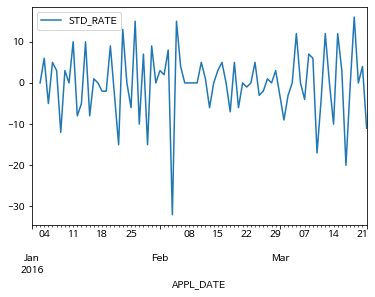

In [20]:
df_USD_diff2 = df_USD_train - 2*(df_USD_train.shift(1)) + (df_USD_train.shift(2))
df_USD_diff2.plot()

# step3 시계열분석 : 자기상관 함수 및 부분 자기상"관 함수

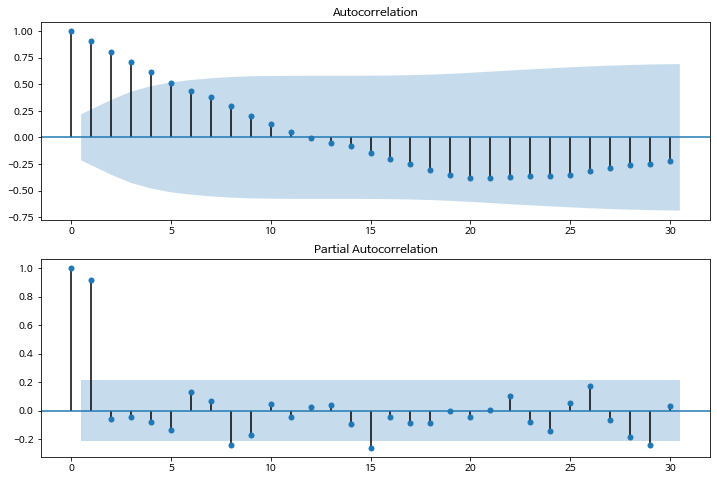

In [21]:
lag_size = 30
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_USD_train['STD_RATE'],lags=lag_size, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_USD_train['STD_RATE'],lags=lag_size, ax=ax2)


# step3 시계열분석 : 시계열모델

In [24]:
ts_model_usd = ARIMA(df_USD_train, order=(1,2,0))

ts_result_usd = ts_model_usd.fit(trend='c', full_output=True)
print(ts_result_usd.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -274.800
Method:                       css-mle   S.D. of innovations              7.502
Date:                Fri, 07 Feb 2020   AIC                            555.601
Time:                        14:54:34   BIC                            562.747
Sample:                    01-03-2016   HQIC                           558.466
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0502      0.612     -0.082      0.935      -1.249       1.148
ar.L1.D2.STD_RATE    -0.3763      0.104     -3.622      0.001      -0.580      -0.173
                        

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


# step4 예측 및 결과해석

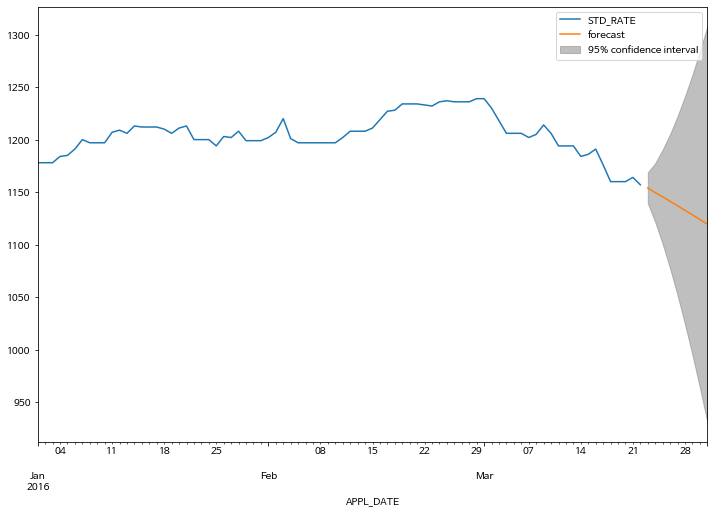

In [25]:
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
fig,ax = plt.subplots(figsize=(12,8))
ax = df_USD_train.plot(ax=ax)

fig = ts_result_usd.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

In [26]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_usd.predict(start=start_time, end=end_time, typ='levels')
df_merge = df_USD
df_merge['예측값'] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,1178.0,NaN
2016-01-02,1178.0,NaN
2016-01-03,1178.0,1177.949753
2016-01-04,1184.0,1177.930843
2016-01-05,1185.0,1187.672879


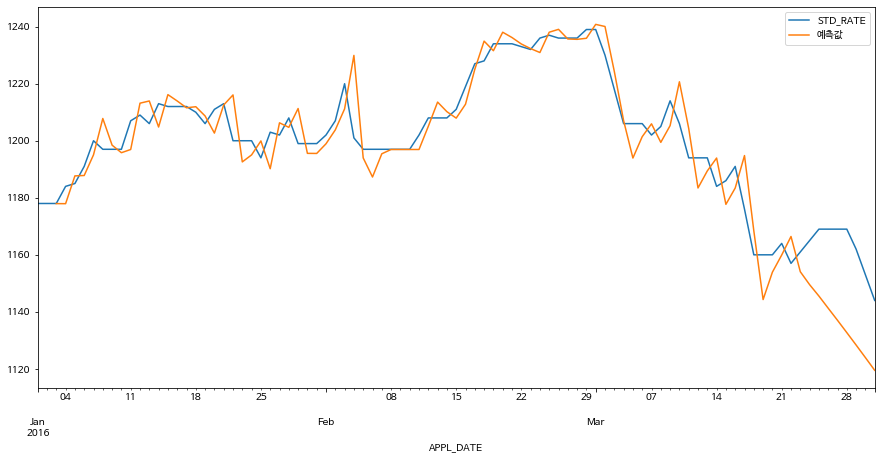

In [27]:
df_merge.plot(y=['STD_RATE', '예측값'],figsize=(15,7))